# Reference:
https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile#Correlation-Analysis
https://github.com/viveksrinivasanss/blogs/blob/master/bike_sharing_demand/eda_%26_ensemble_model.ipynb
https://medium.com/analytics-vidhya/how-to-finish-top-10-percentile-in-bike-sharing-demand-competition-in-kaggle-part-2-29e854aaab7d
https://www.kaggle.com/c/bike-sharing-demand/discussion/10431

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/test.csv


# Data Fields
* datetime - hourlydate + timestamp
* season - 1:spring, 2:summer, 3:fall, 4:winter
* holiday - whether the day is considered a holiday
* workingday - whether a day is niether weekend or a holiday
* weather-
        * 1:clear, few clouds, partly cloudy
        * 2: misty & cloudy, misty&broken clouds, misty&few clouds, misty
        * 3: Light snow, Light Rain&thunder storm & scattered clouds, light rain & scattered clouds
        * 4: Heavy Rain+ Ice pallets+thundersorm+mist, snow+fog
* temp - temperature in celsius
* atemp - "feels like" temperature in celsius
* humidity - relative humidity
* windspeed
* casual - number of non-registered user rental initiated
* registered - number of registered user rentals initiated
* count - number of total rentals(Dependant variable)

In [2]:
import pylab
import pickle
import calendar
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category = DeprecationWarning)
%matplotlib inline


# Reading the Dataset

In [3]:
dailyData = pd.read_csv("../input/bike-sharing-demand/train.csv")

# Data Summary

Next we will see more about the dataset 

* Size of the data
* Glimpse of the dataset
* What of type of variables


# Size of the dataset

In [4]:
dailyData.shape

(10886, 12)

# Sample Rows

In [5]:
dailyData.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


# Data Type

In [6]:
dailyData.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

# Feature Engineering

* The following data arecategorical, but is present in the dataset as int type.
so we need to convert these datas into categorical variables.
    1. Weather 
    2. Season
    3. Holiday
    4. Working Day

* Create the following columns from datetime column
    1. date
    2. hour
    3. weekDay
    4. month

* Drop the datetime column


In [7]:
dailyData.datetime.apply(lambda x:x.split()[0])

0        2011-01-01
1        2011-01-01
2        2011-01-01
3        2011-01-01
4        2011-01-01
            ...    
10881    2012-12-19
10882    2012-12-19
10883    2012-12-19
10884    2012-12-19
10885    2012-12-19
Name: datetime, Length: 10886, dtype: object

In [8]:
#creating new columns from datetime column
# apply() : apply is a function in pandas library. It helps to apply a function(lambda/userdefined/Numpy) to the rows/columns in a dataFrame.
# The default value for axis in apply function is axis = 0 (column).
# lambda function: it takes input as a dataframe(all/specified number rows of a df or all/specified number columns)
dailyData["date"] = dailyData.datetime.apply(lambda x:x.split()[0])
dailyData["hour"] = dailyData.datetime.apply(lambda x: x.split()[1].split(":")[0])
# strptime: create a datetime object from a string 
# datetime.strptime(date_string, format) where datetime is an object that supplies different classes like strptime
# for manipulating and formatting date ot time 
dailyData["weekday"] = dailyData.date.apply(lambda dateString: calendar.day_name[datetime.strptime(dateString, "%Y-%m-%d").weekday()])
dailyData["month"] = dailyData.date.apply(lambda dateString: calendar.month_name[datetime.strptime(dateString, "%Y-%m-%d").month])
dailyData["season"] = dailyData.season.map({1:"Spring", 2:"Summer", 3:"Fall", 4:"winter"})
dailyData["weather"] = dailyData.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

In [9]:
#creating category variables
#A categorical variable is one that usually takes a fixed, number of possible values
categoryvariables = ["hour", "weekday", "month", "season", "weather", "holiday", "workingday"]
for var in categoryvariables:
    dailyData[var] = dailyData[var].astype("category")

In [10]:
#Dropping Datetime column
dailyData = dailyData.drop(["datetime"], axis =1)

# Visualizing the total number of each datatypes present in the dataset

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'variableType'),
 Text(0.5, 1.0, 'Count of the different Datatypes')]

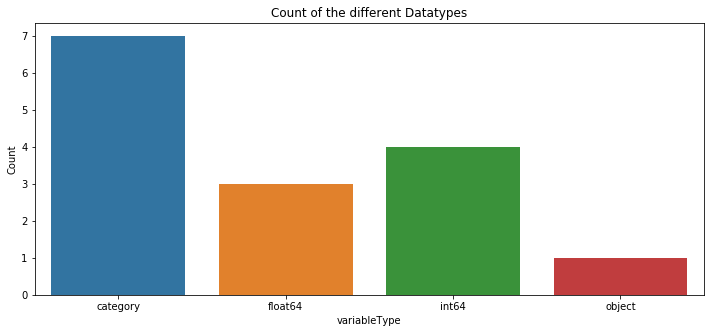

In [11]:
#creating the data for the plot
typesCountSerie = dailyData.dtypes.value_counts()

# format columns as arrays of either strings or integers
# typeNames are easier to sort as array of `string` rather than an array of `dtype`
typeNamesColumn = list(map(lambda t: t.name , typesCountSerie.index.values));
typeCountColumn = typesCountSerie.values
# create an initial dataframe, with multiple occurences of the same "variableType"
intialDataTypeDf = pd.DataFrame({
    "variableType": typeNamesColumn, 
    "count": typeCountColumn
})

# Group initial data frame by "variableType", 
# then reset_index to have a proper dataframe
groupedDataTypeDf = intialDataTypeDf.groupby(['variableType']).sum()[['count']].reset_index()
#dataTypeDf = pd.DataFrame(dailyData.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(12, 5)
#plotting the barchart
sn.barplot(data=groupedDataTypeDf, x="variableType", y="count", ax=ax)
ax.set(xlabel = 'variableType', ylabel = 'Count', title = "Count of the different Datatypes")

# Missing Value

Matrix :
Using this matrix you can very quickly find the pattern of missingness in the dataset. 

Bar Chart :
This bar chart gives you an idea about how many missing values are there in each column.

No Missing values detected.

* Checking the presence of missing values by visualising using "msno"

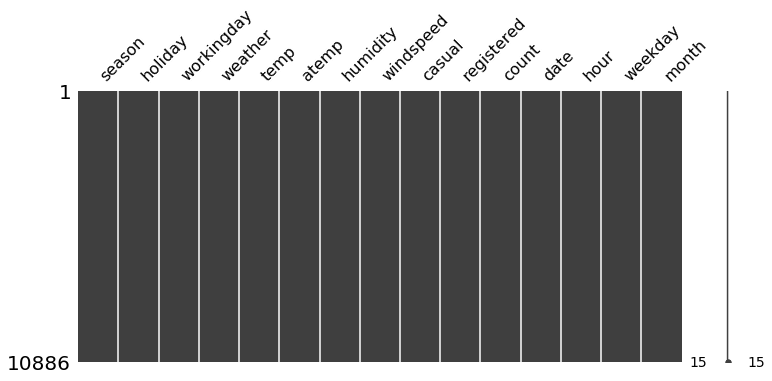

In [12]:
msno.matrix(dailyData, figsize=(12,5))

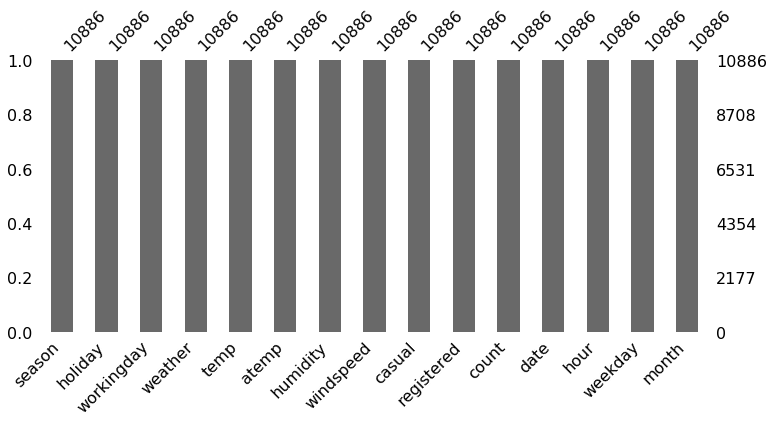

In [13]:
msno.bar(dailyData, figsize=(12,5))

Now it is confirmed that there are no missing values.

# Heatmap :
Heatmap shows the correlation of missingness between every 2 columns. In our example, the correlation between AAWhiteSt-4 and SulphidityL-4 is 1 which means if one of them is present then the other one must be present.

A value near -1 means if one variable appears then the other variable is very likely to be missing.
A value near 0 means there is no dependence between the occurrence of missing values of two variables.
A value near 1 means if one variable appears then the other variable is very likely to be present.


# Detecting Outliers
Analysis using Boxplots

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Box Plot On Count  across Working day')]

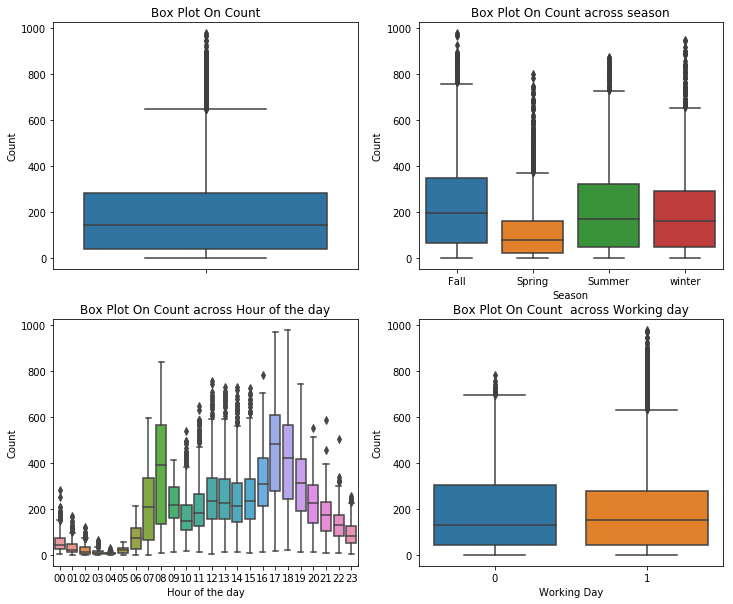

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12,10)
sn.boxplot(data = dailyData, y = "count", orient = "v", ax=axes[0][0])
sn.boxplot(data = dailyData, y = "count", x = "season", orient = "v", ax=axes[0][1])
sn.boxplot(data = dailyData, y = "count", x= "hour", orient = "v", ax=axes[1][0])
sn.boxplot(data = dailyData, y = "count", x = "workingday", orient = "v", ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel = 'Season', ylabel='Count',title="Box Plot On Count across season")
axes[1][0].set(xlabel = 'Hour of the day', ylabel='Count',title="Box Plot On Count across Hour of the day")
axes[1][1].set(xlabel = 'Working Day', ylabel='Count',title="Box Plot On Count  across Working day")

# About Box Plot
A box and whisker plot—also called a box plot—displays the five-number summary of a set of data. The five-number summary is the minimum, first quartile, median, third quartile, and maximum. In a box plot, we draw a box from the first quartile to the third quartile. A vertical line goes through the box at the median.

# Observation from the above box plot
* The count has many 'outliers' as it exceeds the outer quartile limit.
* Spring Season has got relatively lower count.
* The box plot for "Hour of the day " infer that the median values are higher at 7AM- 8AM, and 5pm-6pm.
These time indicates regular office and school hours.
* Most of the 'outliers' are contributed by 'working days' rather than 'non-working days'.

# Removing Outliers

In [15]:
#checking how many count values are with in 3*standard deviation
np.sum(np.abs(dailyData["count"]-dailyData["count"].mean())<=(3*dailyData["count"].std()))



10739

In [16]:
dailyDataWithoutOutliers = dailyData[np.abs(dailyData["count"]-dailyData["count"].mean())<=(3*dailyData["count"].std())]

In [17]:
print("shape of the data with outliers", dailyData.shape)
print("shape of the data without outliers", dailyDataWithoutOutliers.shape)

shape of the data with outliers (10886, 15)
shape of the data without outliers (10739, 15)


# Correlation Analysis
* To determine the relationship a dependent variable is having with the numerical features.
* Below are the data types of numerical features(non-categorical)(temp, atemp, casual, registered, humidity) and dependend variable(count)

In [18]:
dailyData[["temp","atemp","casual","registered","humidity","windspeed","count"]].dtypes



temp          float64
atemp         float64
casual          int64
registered      int64
humidity        int64
windspeed     float64
count           int64
dtype: object

# Plotting the corrrelation between Count and the ("temp","atemp","casual","registered","humidity","windspeed")

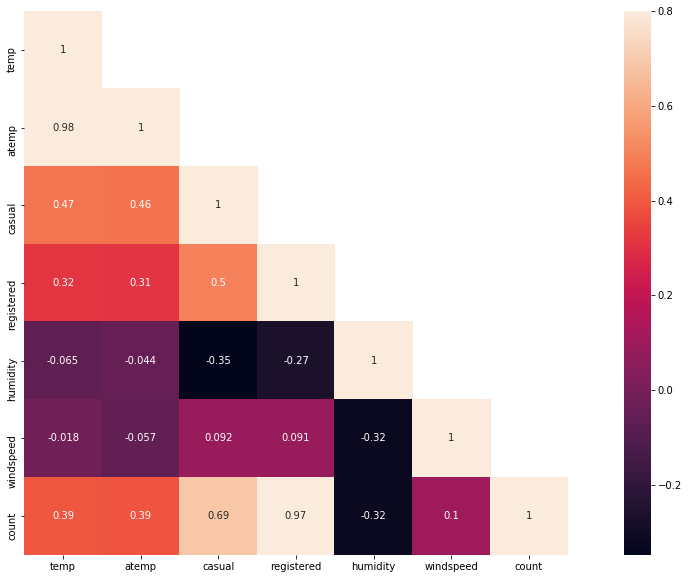

In [19]:
dailyDataCorr = dailyData[["temp","atemp","casual","registered","humidity","windspeed", "count"]].corr()
mask = np.array(dailyDataCorr)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(dailyDataCorr, mask = mask, vmax = .8, square = True, annot = True)

* temp and humidity features are showing positive and negative correlation with the count variable. Although the correlation between them are not prominent, the count has little dependency with them.
* windspeed is not really going to be useful. The correlation value with count is 0.1.
* atemp has a strong relationship with temp. So one of the variable has to be dropped during model building since they exhibit multicollinearity in the data.
* Casual and registered variables are not considered since they are leakage variables. 
* casual(non registered)+registered = count

# Multicollinearity 

There are certain reasons why multicollinearity occurs:

* It is caused by an inaccurate use of dummy variables.
* It is caused by the inclusion of a variable which is computed from other variables in the data set.
* Multicollinearity can also result from the repetition of the same kind of variable.
* Generally occurs when the variables are highly correlated to each other.

Multicollinearity can result in several problems. These problems are as follows:

* The partial regression coefficient due to multicollinearity may not be estimated precisely. The standard errors are likely to be high.
* Multicollinearity results in a change in the signs as well as in the magnitudes of the partial regression coefficients from one sample to another sample.
* Multicollinearity makes it tedious to assess the relative importance of the independent variables in explaining the variation caused by the dependent variable.

Partial regression coefficient
* A value indicating the effect of each independent variable on the dependent variable with the influence of all the remaining variables held constant. Each coefficient is the slope between the dependent variable and each of the independent variables


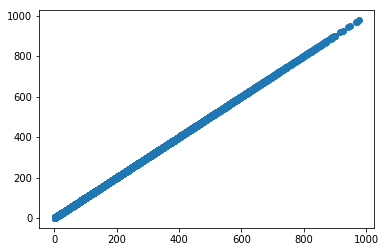

In [20]:
#casual(non registered)+registered = count
#https://www.kaggle.com/jjuanramos/bike-sharing-demand
plt.scatter(x = dailyData['casual'] + dailyData['registered'], y = dailyData['count'])
plt.show()

# Regression Plot
Regression plot in seaborn is one useful way to depict the relationship between two features. Here we consider "count" vs "temp", "humidity", "windspeed".
* a partial regression plot attempts to show the effect of adding another variable to a model that already has one or more independent variables. Partial regression plots are also referred to as added variable plots, adjusted variable plots, and individual coefficient plots.

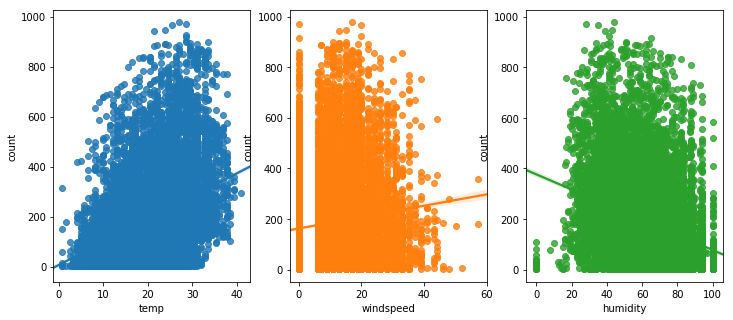

In [21]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x="temp", y="count", data=dailyData,ax=ax1)
sn.regplot(x="windspeed", y="count", data=dailyData,ax=ax2)
sn.regplot(x="humidity", y="count", data=dailyData,ax=ax3)

# Data Distribution

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909617))

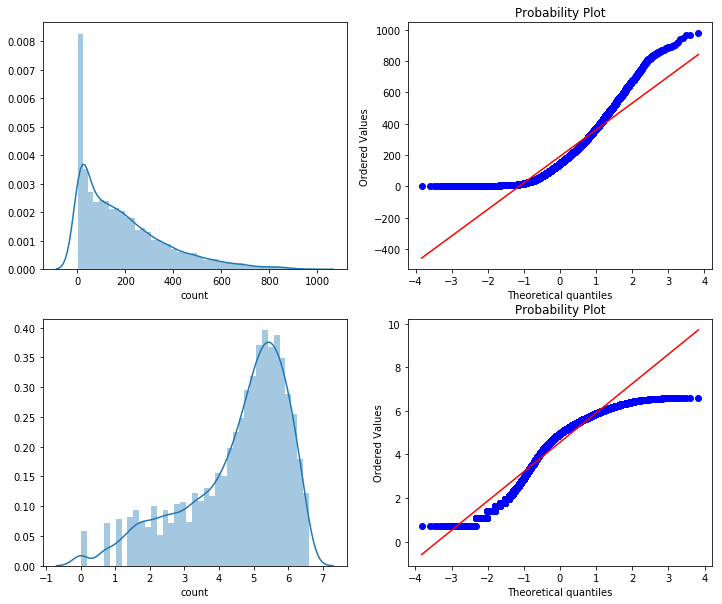

In [22]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sn.distplot(dailyData["count"],ax=axes[0][0])
stats.probplot(dailyData["count"], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(np.log(dailyDataWithoutOutliers["count"]),ax=axes[1][0])
stats.probplot(np.log1p(dailyDataWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

As it is visible from the below figures that "count" variable is skewed towards right. It is desirable to have Normal distribution as most of the machine learning techniques require dependent variable to be Normal. One possible solution is to take log transformation on "count" variable after removing outlier data points. After the transformation the data looks lot better but still not ideally following normal distribution.

# Visualizing Count Vs (Month,Season,Hour,Weekday,Usertype)

[Text(0, 0.5, 'Avearage Count'),
 Text(0.5, 0, 'Month'),
 Text(0.5, 1.0, 'Average Count By Month')]

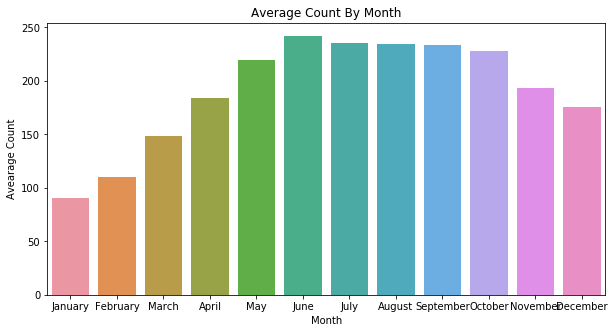

In [23]:
fig,(ax1)= plt.subplots(nrows=1)
fig.set_size_inches(10,5)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(dailyData.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sn.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

[Text(0, 0.5, 'Users Count'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across Season'),
 None]

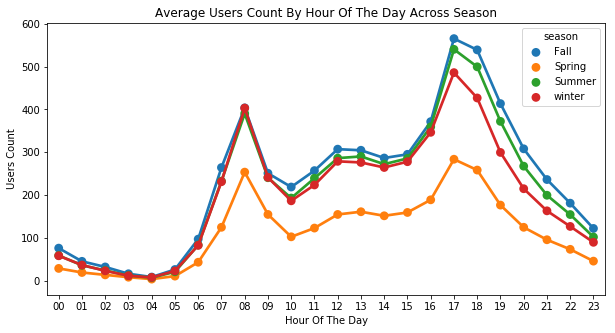

In [24]:
fig,ax2= plt.subplots(nrows=1)
fig.set_size_inches(10,5)
hourAggregated = pd.DataFrame(dailyData.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

[Text(0, 0.5, 'Users Count'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across Weekdays'),
 None]

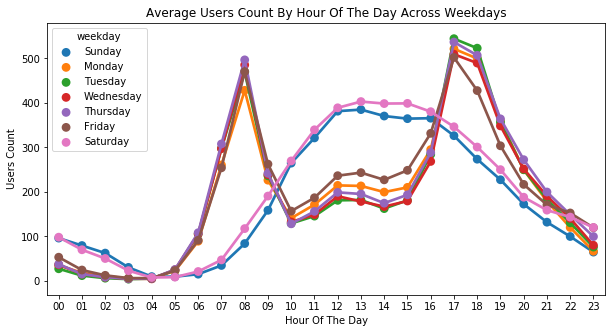

In [25]:
fig,ax3 = plt.subplots(nrows = 1)
fig.set_size_inches(10,5)
hourAggregated = pd.DataFrame(dailyData.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

[Text(0, 0.5, 'Users Count'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across User Type'),
 None]

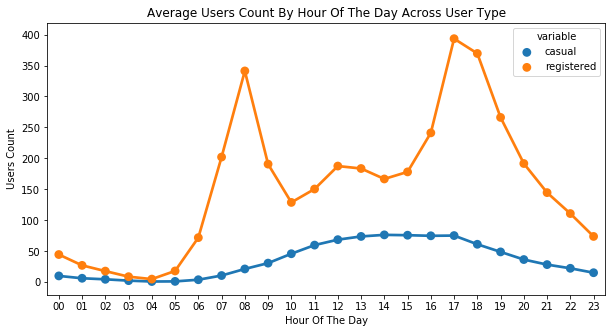

In [26]:
fig, ax4 = plt.subplots(nrows=1)
fig.set_size_inches(10, 5)
hourTransformed = pd.melt(dailyData[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

* It is quiet obvious that people tend to rent bike during summer season since it is really conducive to ride bike at that season.Therefore June, July and August has got relatively higher demand for bicycle.
* On weekdays more people tend to rent bicycle around 7AM-8AM and 5PM-6PM. As we mentioned earlier this can be attributed to regular school and office commuters.
* Above pattern is not observed on "Saturday" and "Sunday".More people tend to rent bicycle between 10AM and 4PM.
* The peak user count around 7AM-8AM and 5PM-6PM is purely contributed by registered user.

# Data Modeling and predicting

Filling Zeros in windspeed using Random Forest

In [27]:
dataTrain = pd.read_csv("../input/bike-sharing-demand/train.csv")
dataTest = pd.read_csv("../input/bike-sharing-demand/test.csv")

In [28]:
#combine test and train data
data = dataTrain.append(dataTest)
data.reset_index(inplace = True)
data.drop('index', inplace = True, axis = 1)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# Feature Engineering

In [29]:
data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)
dataWindspeedOriginal = data["windspeed"]

[Text(17.200000000000003, 0.5, 'Count'),
 Text(0.5, 17.200000000000003, 'windspeed Values'),
 Text(0.5, 1.0, 'Count of windspeed values before imputing')]

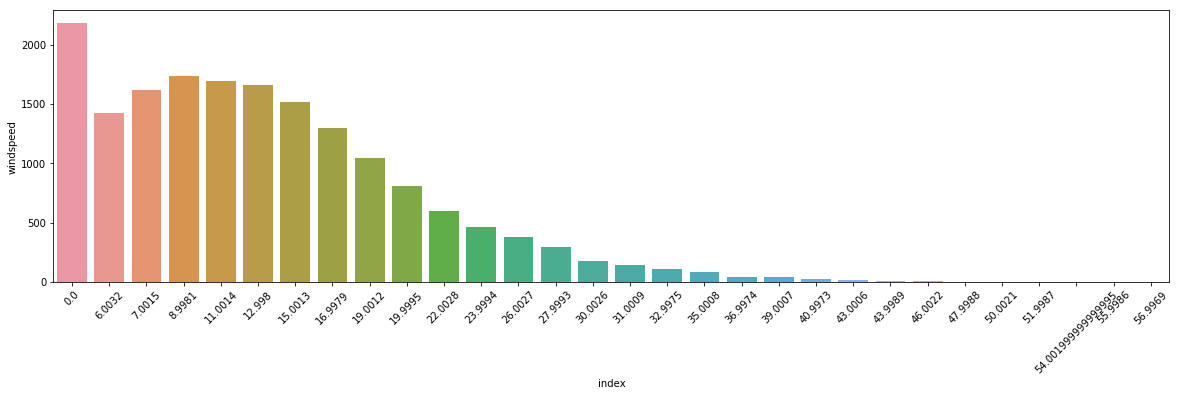

In [30]:
fig,ax= plt.subplots(nrows=1)
fig.set_size_inches(20,5)
#sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
#hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

windspeed = pd.DataFrame(data.windspeed.value_counts()).reset_index()
plt.xticks(rotation=45) 
sn.barplot(data=windspeed,x="index",y="windspeed",ax=ax)
ax1.set(xlabel='windspeed Values', ylabel='Count',title="Count of windspeed values before imputing")

Windspeed has many zero entries which make it look suspicious.

As specified in the kaggle discussion:
* It can actually be 0 at these points.
* It is too low to be measured, for example varying from 0 to 5.
* All zeros or part of them are nothing but NAs.

Considering windspeed 0 entries as missing values, we will fill them with Random Forest Classifier model.

In [31]:
from sklearn.ensemble import RandomForestClassifier
wCol= ["season","weather","humidity","month","temp","year","atemp"]
#dataWind0 is the entire dataset(contains cols season, weather, humidity, month, temp, year, atemp)
#with windspeed value = 0
dataWind0 = data[data["windspeed"] == 0]
#dataNotWind0 is the entire dataset(contains cols season, weather, humidity, month, temp, year, atemp)
#without windspeed value = 0
dataWindNot0 = data[data["windspeed"] != 0]
dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

#predicting value for windspeed = 0
rfModel_wind = RandomForestClassifier()
rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])
Wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

dataWind0["windspeed"] = Wind0Values
data = dataWindNot0.append(dataWind0)
data["windspeed"] = data["windspeed"].astype("float")
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)



/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# After Imputing Windspeed values

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Windspeed Values'),
 Text(0.5, 1.0, 'Count Of Windspeed Values After Imputing'),
 None]

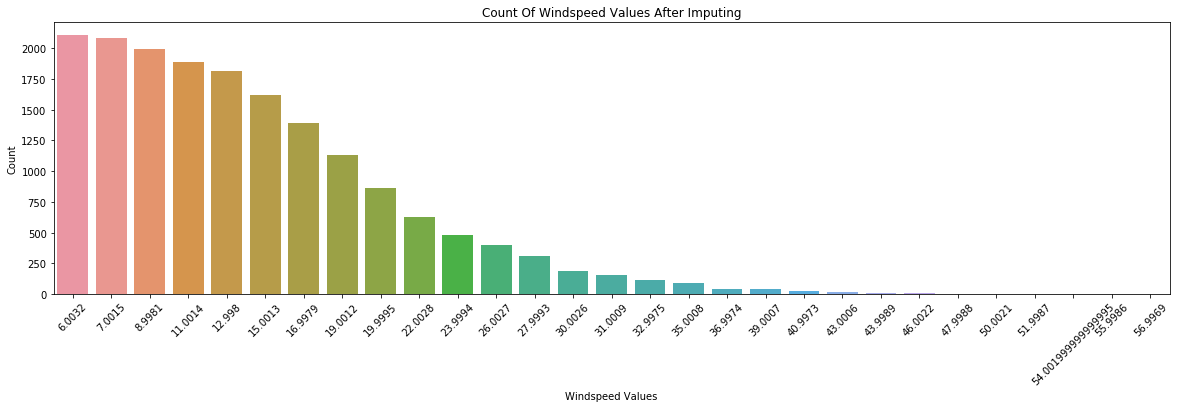

In [32]:
fig, ax =plt.subplots(nrows=1)
fig.set_size_inches(20,5)
windspeed = pd.DataFrame(data.windspeed.value_counts()).reset_index()
plt.xticks(rotation=45) 
sn.barplot(data=windspeed,x="index",y="windspeed",ax=ax)
ax.set(xlabel='Windspeed Values', ylabel='Count',title="Count Of Windspeed Values After Imputing",label='big')

# Coercing to Categorical Type

In [33]:
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"count","datetime","date","registered"]

In [34]:
for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

In [35]:
data.head()

,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday,date,hour,year,weekday,month
0,12.880,0.0,1.0,2011-01-01 05:00:00,0,75,1.0,1,9.84,2,6.0032,0,2011-01-01,5,2011,5,1
1,19.695,12.0,36.0,2011-01-01 10:00:00,0,76,24.0,1,15.58,1,16.9979,0,2011-01-01,10,2011,5,1
2,16.665,26.0,56.0,2011-01-01 11:00:00,0,81,30.0,1,14.76,1,19.0012,0,2011-01-01,11,2011,5,1
3,21.210,29.0,84.0,2011-01-01 12:00:00,0,77,55.0,1,17.22,1,19.0012,0,2011-01-01,12,2011,5,1
4,22.725,47.0,94.0,2011-01-01 13:00:00,0,72,47.0,1,18.86,2,19.9995,0,2011-01-01,13,2011,5,1


# Splitting Train and Test Data

In [36]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])#datatime is not droppe, month, week etc are created from it.
dataTest = data[~pd.notnull(data['count'])].sort_values(by = ["datetime"])
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
yLabelsRegistered = dataTrain["registered"]
yLabelsCasual = dataTrain["casual"]

# Splitting Train and Validator

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split( dataTrain, yLabels, test_size=0.3, random_state=42)
dateTimeColValidate = X_validate["datetime"]

# Dropping Unnecessary Features

In [38]:
dataTrain  = dataTrain.drop(dropFeatures,axis=1)
dataTest  = dataTest.drop(dropFeatures,axis=1)
X_train = X_train.drop(dropFeatures,axis=1)
X_validate = X_validate.drop(dropFeatures,axis=1)

# RMSLE Scorer
* One common way to evaluate the regression model is through calculating MSE or RMSE. In this particular competition, the metric to evaluate our model is* Root Mean Square Logarithmic Error* (RMSLE). RMSLE is particularly helpful when you want to penalize an under-predicted estimate greater than an over-predicted estimate.
Most of the Kaggle competition where we predict sales and inventory demand especially use RMSLE as their metric to evaluate. For example competition such as grupo-bimbo-inventory-demand and sberbank-russian-housing-market use RMSLE as a metric.
![](http://miro.medium.com/max/923/1*9P4NEvK5qYN5Bhu0yOEzhw.png)
Unfortunately, sklearn metrics do not have the direct implementation to calculate RMSLE. So let us construct a custom function to perform theRMSLE calculation.

In [39]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [40]:
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

Data is prepared by filling the missing values and constructed the RMSLE scorer. So we are now good to go for our model building experimet.

# Linear Regression
* As a first step, let us start with a simple statistical technique like linear regression. It is always good to start from a simple model than to try complex machine learning algorithms at first. Because at times features will have a smooth, nearly linear dependence on the covariates. Then linear regression will model the dependence better than anrandom forest algorithm that will basically approximate a linear curve with an ugly irregular step function. A StackExchange discussion gives loads of information about it.
https://stats.stackexchange.com/questions/174806/linear-regression-performing-better-than-random-forest-in-caret

In [41]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV

#Initialize Logistic Regression model
lModel = LinearRegression()
# Train the model
lModel.fit(X = X_train,y = np.log1p(y_train))
# Make predictions
preds = lModel.predict(X= X_validate)
print ("RMSLE Value For Linear Regression In Validation: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds),False))

RMSLE Value For Linear Regression In Validation:  0.9829552548428286


* Before submitting our test results we will visualize the distribution of train and test results. Kaggle has a limit on the number of submissions per day. (in our case it is 5 submissions/day). So visualizing the distribution gives a good clue on how close we have predicted our test based on our training set. From the figure it visible that the distribution of the train and test set vary considerably.

[Text(0.5, 1.0, 'Test Set Distribution')]

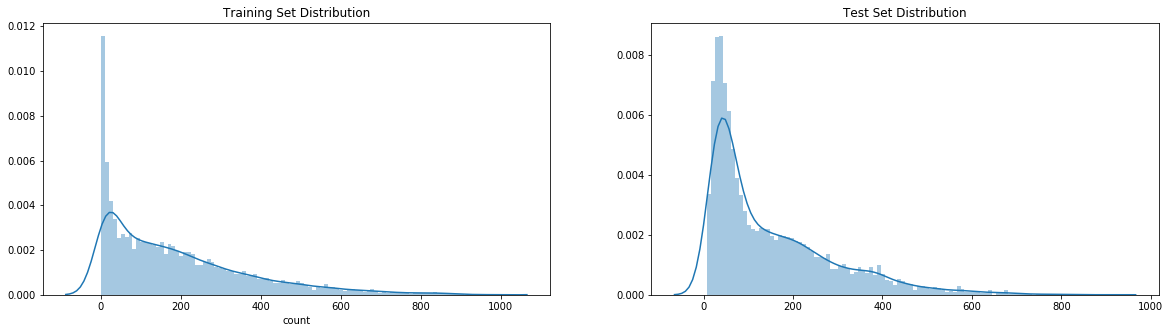

In [42]:
predsTest = lModel.predict(X=dataTest)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(20,5)
sn.distplot(yLabels,ax=ax1,bins=100)
sn.distplot(np.exp(predsTest),ax=ax2,bins=100)
ax1.set(title="Training Set Distribution")
ax2.set(title="Test Set Distribution")

In [43]:
#print ("RMSLE Value For Linear Regression In Validation: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(predsTest),False))

The RMSLE value on the test set is around 1.05 and it is definitely not on par with the best score(0.33) in theKaggle leaderboard. We can improve this score substantially in a number of ways.
* Feature Engineering
* Regularization (L1 & L2)
* Ensemble Models
1. We have already created a few features such as weekday, month, hour from the datetime attribute. And there are many numbers of ways one can come with feature engineering steps. As a part of this blog, I am not taking that into consideration and I will leave that to the imagination of users.

# Regularization

Regularization is extremely useful in any of these cases. Multicollinearity and overfitting may pose some issues for us.

* overfitting
* A large number of variables
* Low ratio of number of observations to number of variables
* Multicollinearity
* Overfitting refers to a model that performs well on the training set by learning the detail and noise in the training data but does not generalize well on the new set of data. Let us take our example, RMSLE value on training data is around 0.98 and there is no big difference from the test set results.So far we do not have  any overfitting problems but at imes it will be a nightmare while fitting the models. 
    >> Having a large number of variables may again result in overfitting. This is because the model becomes more complex and sometimes lowers its predicting and generalization power. ***L1 regularization(Lasso Regression)***comes in handy in these situations by reducing the coefficients to zero thereby producing simpler models.
    >*** L2 Regularization***(Ridge Regression) is extremely helpful for the third case where we have the ratio of more number of attributes
    to less number of observation.But in this case, we are fine with that with 12 attributes and 10886 records. Ridge regression is also when there is high multicollinearity between predictor variables. We have highly correlated variables like temp-atemp and month-season.
    > So we are not getting affected much with the above problems. But to improve our score, we will build simple regularization models.

# Regularization Model - Ridge(L2)

{'alpha': 100, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9830317930161081


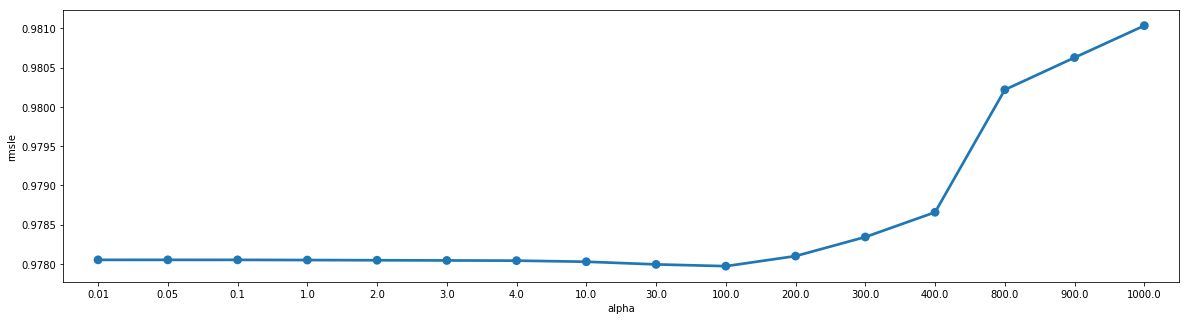

In [44]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01,0.05,0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better = False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)
grid_ridge_m.fit(X = X_train, y = np.log1p(y_train))
preds = grid_ridge_m.predict(X = X_validate)
print(grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds),False))

fig,ax= plt.subplots()
fig.set_size_inches(20,5)
df = pd.DataFrame(grid_ridge_m.cv_results_)
df
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

# L1 Regularization(Lasso)

{'alpha': 0.005, 'max_iter': 3000}
RMSLE Value:  0.9829759514784537


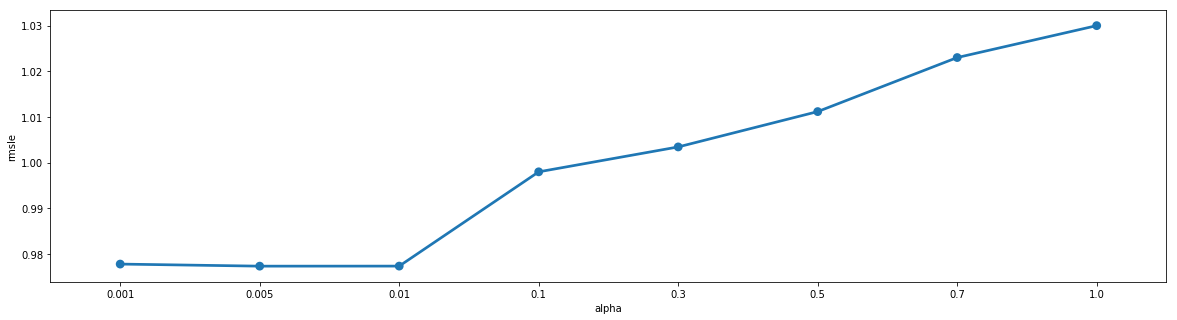

In [45]:
from sklearn.linear_model import Lasso
lasso_m_ = Lasso()
alpha  = [0.001,0.005,0.01,0.3,0.1,0.3,0.5,0.7,1]
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}
#rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_lasso_m = GridSearchCV(lasso_m_, lasso_params_, scoring = rmsle_scorer, cv = 5)
grid_lasso_m.fit(X = X_train,y = np.log1p(y_train))
preds = grid_lasso_m.predict(X= X_validate)
print (grid_lasso_m.best_params_)
print ("RMSLE Value: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds), False))

fig,ax= plt.subplots()
fig.set_size_inches(20,5)
df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

The optimum value of the regularization parameter (alpha-0.005) is obtained through a grid search. The chart below visualizes RMSLE values for different alpha parameters. RMSLE value on the test set is around 1.04 and has not improved from our previous. So regularization has not given any boost to our score. But let us not lose hope because when nothing goes right ensemble model always produces something out of the box for us.

# Ensemble Models
> Ensemble models are nothing but an art of combining a diverse set of individual weak learners(models) together to improve the stability and predictive capacity of the model. Ensemble Models improves the performance of the model by
* Averaging out biases.
* Reducing the variance.
* Avoiding overfitting.
 >> If you are still wondering what ensemble model is all about then this series of articles can get you started with it. So that’s enough introduction about ensemble model and here is a snippet on how we fit naive Random Forest model on our dataset with default parameters.

In [46]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)
rfModel.fit(X = X_train,y = np.log1p(y_train))
preds = rfModel.predict(X= X_validate)
print ("RMSLE Value: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds), False))

RMSLE Value:  0.28465645644851284


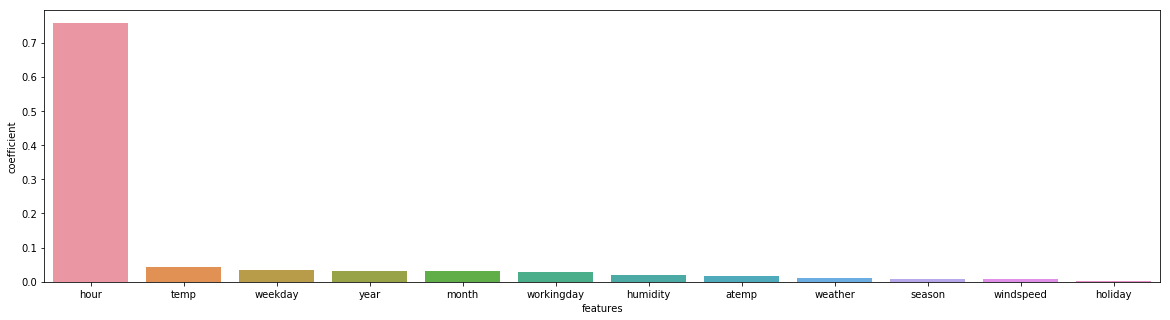

In [47]:
features = pd.DataFrame()
features['features'] = X_train.columns
features['coefficient'] = rfModel.feature_importances_
features.sort_values(by=['coefficient'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sn.barplot(data=features,x="features",y="coefficient",ax=ax)

[Text(0.5, 1.0, 'Test Set Distribution')]

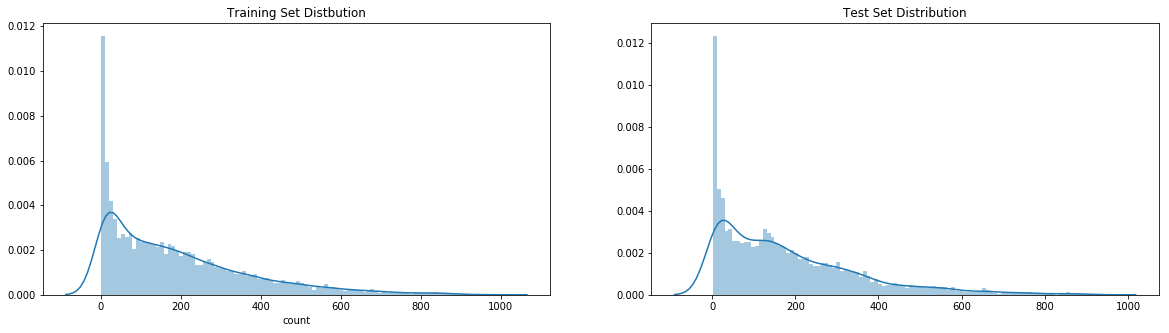

In [48]:
predsTest = rfModel.predict(X=dataTest)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(20,5)
sn.distplot(yLabels,ax=ax1,bins=100)
sn.distplot(np.exp(predsTest),ax=ax2,bins=100)
ax1.set(title="Training Set Distbution")
ax2.set(title="Test Set Distribution")

In [49]:
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in np.exp(predsTest)]
    })
submission.to_csv('bike_predictions_gbm_separate_without_fe.csv', index=False)